# TalkingData: Fraudulent Click Prediction






In this notebook, we will apply various boosting algorithms to solve an interesting classification problem from the domain of 'digital fraud'.

The analysis is divided into the following sections:
- Understanding the business problem
- Understanding and exploring the data
- Feature engineering: Creating new features
- Model building and evaluation: AdaBoost
- Modelling building and evaluation: Gradient Boosting
- Modelling building and evaluation: XGBoost


## Understanding the Business Problem

<a href="https://www.talkingdata.com/">TalkingData</a> is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, **click fraud** is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping **approx. 70% of the active mobile devices in China**, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download). 

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released <a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection">the problem on Kaggle here.</a>.

## Understanding and Exploring the Data

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0). 

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:
- ```ip```: ip address of click.
- ```app```: app id for marketing.
- ```device```: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- ```os```: os version id of user mobile phone
- ```channel```: channel id of mobile ad publisher
- ```click_time```: timestamp of click (UTC)
- ```attributed_time```: if user download the app for after clicking an ad, this is the time of the app download
- ```is_attributed```: the target that is to be predicted, indicating the app was downloaded

Let's try finding some useful trends in the data.

In [135]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

#### Reading the Data  

The code below reads the train_sample.csv file if you set testing = True, else reads the full train.csv file. You can read the sample while tuning the model etc., and then run the model on the full data once done.

#### Important Note: Save memory when the data is huge

Since the training data is quite huge, the program will be quite slow if you don't consciously follow some best practices to save memory. This notebook demonstrates some of those practices. 

In [3]:
# reading training data

# specify column dtypes to save memory (by default pandas reads some columns as floats)
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }

# read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

# read training data
train_sample = pd.read_csv(train_path, skiprows=skiprows, nrows=nrows, dtype=dtypes, usecols=colnames)


In [4]:
# length of training data
len(train_sample.index)

100000

In [9]:
# Displays memory consumed by each column ---
print(train_sample.memory_usage())

Index                80
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    100000
dtype: int64


In [6]:
# space used by training data
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 1.8120574951171875 MB


In [8]:
# training data top rows
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


### Exploring the Data - Univariate Analysis


Let's now understand and explore the data. Let's start with understanding the size and data types of the train_sample data.

In [11]:
# look at non-null values, number of entries etc.
# there are no missing values
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
ip               100000 non-null uint16
app              100000 non-null uint16
device           100000 non-null uint16
os               100000 non-null uint16
channel          100000 non-null uint16
click_time       100000 non-null object
is_attributed    100000 non-null uint8
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


In [15]:
# Basic exploratory analysis 

# Number of unique values in each column
def fraction_unique(x):
    return len(train_sample[x].unique())

number_unique_vals = {x: fraction_unique(x) for x in train_sample.columns}
number_unique_vals

{'app': 161,
 'channel': 161,
 'click_time': 80350,
 'device': 100,
 'ip': 28470,
 'is_attributed': 2,
 'os': 130}

In [23]:
# All columns apart from click time are originally int type, 
# though note that they are all actually categorical 
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     uint8
dtype: object

There are certain 'apps' which have quite high number of instances/rows (each row is a click). The plot below shows this. 

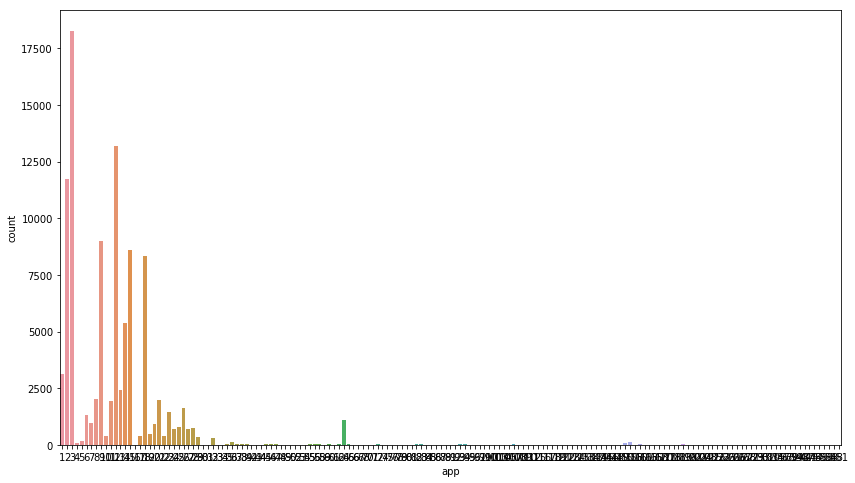

In [24]:
# # distribution of 'app' 
# # some 'apps' have a disproportionately high number of clicks (>15k), and some are very rare (3-4)
plt.figure(figsize=(14, 8))
sns.countplot(x="app", data=train_sample)

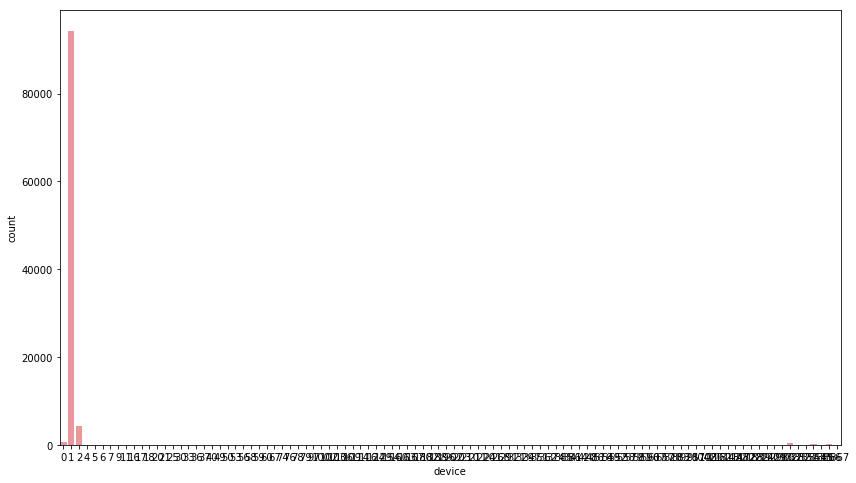

In [25]:
# # distribution of 'device' 
# # this is expected because a few popular devices are used heavily
plt.figure(figsize=(14, 8))
sns.countplot(x="device", data=train_sample)

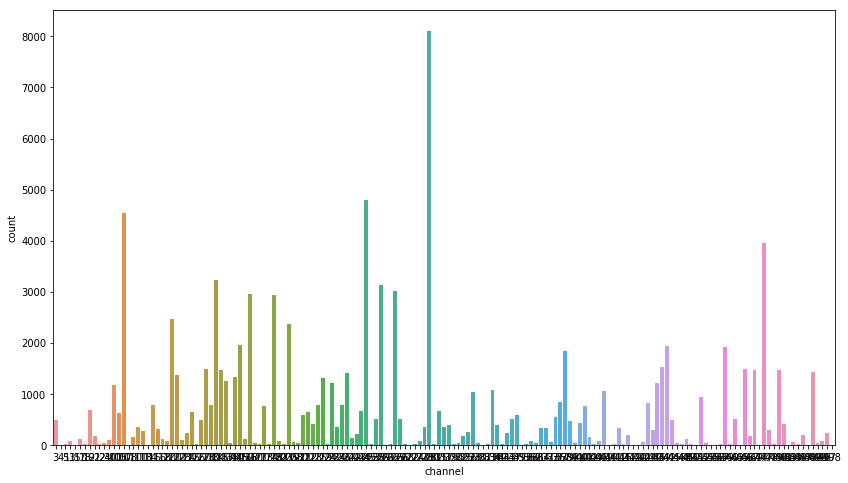

In [26]:
# # channel: various channels get clicks in comparable quantities
plt.figure(figsize=(14, 8))
sns.countplot(x="channel", data=train_sample)

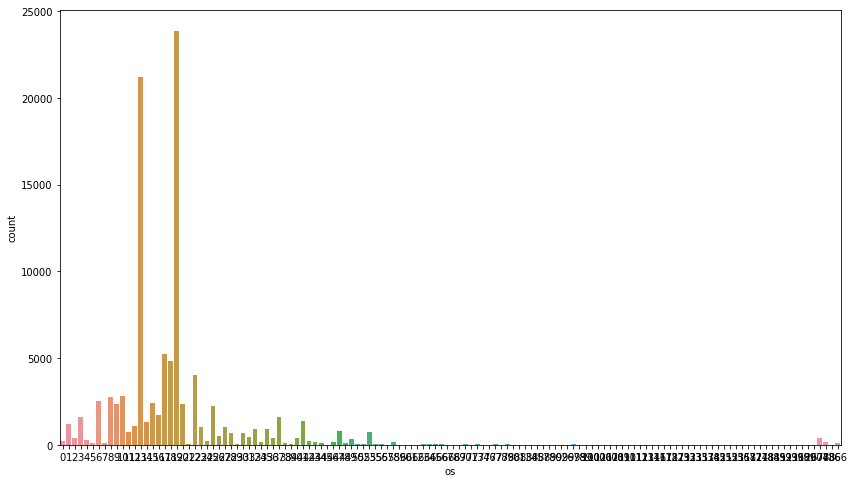

In [27]:
# # os: there are a couple commos OSes (android and ios?), though some are rare and can indicate suspicion 
plt.figure(figsize=(14, 8))
sns.countplot(x="os", data=train_sample)

Let's now look at the distribution of the target  variable 'is_attributed'.

In [28]:
# # target variable distribution
100*(train_sample['is_attributed'].astype('object').value_counts()/len(train_sample.index))

0    99.773
1     0.227
Name: is_attributed, dtype: float64

Only **about 0.2% of clicks are 'fraudulent'**, which is expected in a fraud detection problem. Such high class imbalance is probably going to be the toughest challenge of this problem.

### Exploring the Data - Segmented Univariate Analysis

Let's now look at how the target variable varies with the various predictors.

In [35]:
# plot the average of 'is_attributed', or 'download rate'
# with app (clearly this is non-readable)
app_target = train_sample.groupby('app').is_attributed.agg(['mean', 'count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
6,0.000000,1303
7,0.000000,981
8,0.001996,2004
9,0.000890,8992


This is clearly non-readable, so let's first get rid of all the apps that are very rare (say which comprise of less than 20% clicks) and plot the rest.

In [63]:
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps = frequent_apps.merge(train_sample, on='app', how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,1,3135,17059,1,17,135,0,3,313,11,1
1,1,3135,52432,1,13,115,0,1,311,11,17
2,1,3135,23706,1,27,124,0,1,311,11,9
3,1,3135,58458,1,19,101,0,3,313,11,14
4,1,3135,34067,1,15,134,0,1,311,11,15


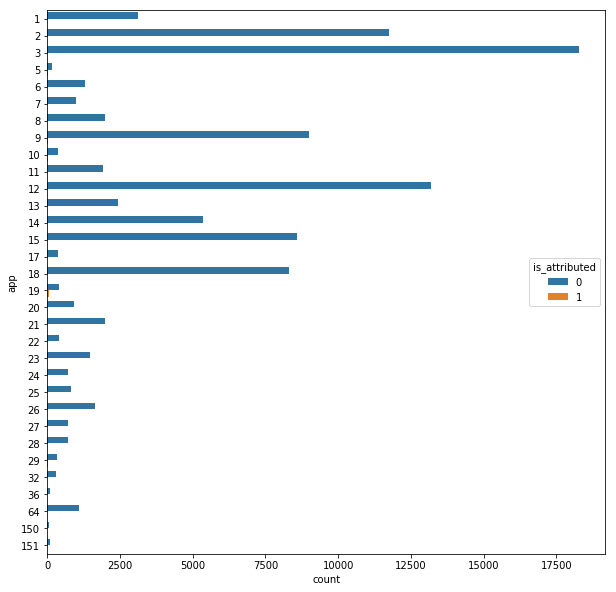

In [64]:
plt.figure(figsize=(10,10))
sns.countplot(y="app", hue="is_attributed", data=frequent_apps);

You can do lots of other interesting ananlysis with the existing features. For now, let's create some new features which will probably improve the model.

## Feature Engineering

Let's now derive some new features from the existing ones. There are a number of features one can extract from ```click_time``` itself, and by grouping combinations of IP with other features.

### Datetime Based Features


In [45]:
# Creating datetime variables
# takes in a df, adds date/time based columns to it, and returns the modified df
def timeFeatures(df):
    # Derive new features using the click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df["day_of_year"] = df["datetime"].dt.dayofyear
    df["month"] = df["datetime"].dt.month
    df["hour"] = df["datetime"].dt.hour
    return df

In [46]:
# creating new datetime variables and dropping the old ones
train_sample = timeFeatures(train_sample)
train_sample.drop(['click_time', 'datetime'], axis=1, inplace=True)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [65]:
# datatypes
# note that by default the new datetime variables are int64
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

In [66]:
# memory used by training data
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 4.1008758544921875 MB


In [67]:
# lets convert the variables back to lower dtype again
int_vars = ['app', 'device', 'os', 'channel', 'day_of_week','day_of_year', 'month', 'hour']
train_sample[int_vars] = train_sample[int_vars].astype('uint16')

In [68]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [69]:
# space used by training data
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 1.8120574951171875 MB


### IP Grouping Based Features

Let's now create some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

Note that though we are deriving new features by grouping IP addresses, using IP adress itself as a features is not a good idea. This is because (in the test data) if a new IP address is seen, the model will see a new 'category' and will not be able to make predictions (IP is a categorical variable, it has just been encoded with numbers).

In [71]:
# number of clicks by count of IP address
# note that we are explicitly asking pandas to re-encode the aggregated features 
# as 'int16' to save memory
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count').astype('int16')
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


We can now merge this dataframe with the original training df. Similarly, we can create combinations of various features such as ip_day_hour (count of ip-day-hour combinations), ip_hour_channel, ip_hour_app, etc. 

The following function takes in a dataframe and creates these features.

In [73]:
# creates groupings of IP addresses with other features and appends the new features to the df
def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    # merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df

In [75]:
train_sample = grouped_features(train_sample)

In [76]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [77]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 3.719329833984375 MB


In [79]:
# garbage collect (unused) object
gc.collect()

17431

## Modelling

Let's now build models to predict the variable ```is_attributed``` (downloaded). We'll try the several variants of boosting (adaboost, gradient boosting and XGBoost), tune the hyperparameters in each model and choose the one which gives the best performance.

In the original Kaggle competition, the metric for model evaluation is **area under the ROC curve**.


In [83]:
# create x and y train
X = train_sample.drop('is_attributed', axis=1)
y = train_sample[['is_attributed']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [84]:
# check the average download rates in train and test data, should be comparable
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


### AdaBoost

In [105]:
# adaboost classifier with max 600 decision trees of depth=2
# learning_rate/shrinkage=1.5

# base estimator
tree = DecisionTreeClassifier(max_depth=2)

# adaboost with the tree as base estimator
adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

In [106]:
# fit
adaboost_model_1.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.5, n_estimators=600, random_state=None)

In [107]:
# predictions
# the second column represents the probability of a click resulting in a download
predictions = adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[ 0.5259697 ,  0.4740303 ],
       [ 0.52720083,  0.47279917],
       [ 0.533081  ,  0.466919  ],
       [ 0.52194781,  0.47805219],
       [ 0.51032691,  0.48967309],
       [ 0.52721323,  0.47278677],
       [ 0.5183883 ,  0.4816117 ],
       [ 0.52170927,  0.47829073],
       [ 0.52412251,  0.47587749],
       [ 0.51552875,  0.48447125]])

In [108]:
# metrics: AUC
metrics.roc_auc_score(y_test, predictions[:,1])

0.92838553411843305

### AdaBoost - Hyperparameter Tuning

Let's now tune the hyperparameters of the AdaBoost classifier. In this case, we have two types of hyperparameters - those of the component trees (max_depth etc.) and those of the ensemble (n_estimators, learning_rate etc.). 


We can tune both using the following technique - the keys of the form ```base_estimator_parameter_name``` belong to the trees (base estimator), and the rest belong to the ensemble.

In [171]:
# parameter grid
param_grid = {"base_estimator__max_depth" : [2, 5],
              "n_estimators": [200, 400, 600]
             }

In [163]:
# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6, we'll discuss learning_rate below
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

In [164]:
# run grid search
folds = 3
grid_search_ABC = GridSearchCV(ABC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)


In [165]:
# fit 
grid_search_ABC.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 10.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.6, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 400, 600], 'base_estimator__max_depth': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [166]:
# cv results
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_base_estimator__max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,9.376183,0.209405,0.952831,0.995954,2,200,"{'n_estimators': 200, 'base_estimator__max_dep...",1,0.926966,0.996306,0.975725,0.995094,0.955801,0.996461,0.181631,0.007091,0.020017,0.000611
1,19.704252,0.450558,0.950575,0.997556,2,400,"{'n_estimators': 400, 'base_estimator__max_dep...",2,0.920643,0.997991,0.974585,0.996683,0.956496,0.997996,0.661952,0.029041,0.022416,0.000618
2,30.060021,0.651644,0.949670,0.998278,2,600,"{'n_estimators': 600, 'base_estimator__max_dep...",3,0.921720,0.998494,0.973335,0.997923,0.953955,0.998417,0.482033,0.021417,0.021288,0.000253
3,22.058344,0.310703,0.927757,1.000000,5,200,"{'n_estimators': 200, 'base_estimator__max_dep...",4,0.902362,1.000000,0.943609,1.000000,0.937299,1.000000,0.215702,0.016600,0.018141,0.000000
4,44.099881,0.596813,0.925812,1.000000,5,400,"{'n_estimators': 400, 'base_estimator__max_dep...",5,0.892569,1.000000,0.939832,1.000000,0.945036,1.000000,0.600258,0.002122,0.023602,0.000000
5,67.404276,0.879526,0.916619,1.000000,5,600,"{'n_estimators': 600, 'base_estimator__max_dep...",6,0.886227,1.000000,0.925892,1.000000,0.937740,1.000000,1.195786,0.028958,0.022029,0.000000


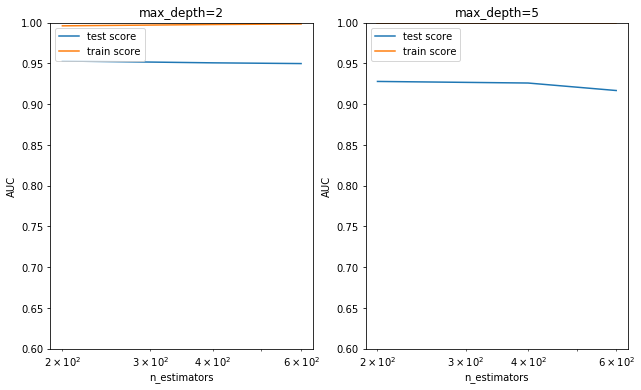

In [170]:
# plotting AUC with hyperparameter combinations

plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    

    # subplot 1/n
    plt.subplot(1,3, n+1)
    depth_df = cv_results[cv_results['param_base_estimator__max_depth']==depth]

    plt.plot(depth_df["param_n_estimators"], depth_df["mean_test_score"])
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"])
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title("max_depth={0}".format(depth))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

    


The results above show that:
- The ensemble with max_depth=5 is clearly overfitting (training auc is almost 1, while the test score is much lower)
- At max_depth=2, the model performs slightly better (approx 95% AUC) with a higher test score 

Thus, we should go ahead with ```max_depth=2``` and ```n_estimators=200```.

Note that we haven't experimented with many other important hyperparameters till now, such as ```learning rate```, ```subsample``` etc., and the results might be considerably improved by tuning them. We'll next experiment with these hyperparameters.

In [183]:
# model performance on test data with chosen hyperparameters

# base estimator
tree = DecisionTreeClassifier(max_depth=2)

# adaboost with the tree as base estimator
# learning rate is arbitrarily set, we'll discuss learning_rate below
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    n_estimators=200,
    algorithm="SAMME")

ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.6, n_estimators=200, random_state=None)

In [184]:
# predict on test data
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[ 0.5880972 ,  0.4119028 ],
       [ 0.58960261,  0.41039739],
       [ 0.60708804,  0.39291196],
       [ 0.57134614,  0.42865386],
       [ 0.55591021,  0.44408979],
       [ 0.58624788,  0.41375212],
       [ 0.56320517,  0.43679483],
       [ 0.58981139,  0.41018861],
       [ 0.59090843,  0.40909157],
       [ 0.56433022,  0.43566978]])

In [185]:
# roc auc
metrics.roc_auc_score(y_test, predictions[:, 1])

0.94789331551546541

### Gradient Boosting Classifier

Let's now try the gradient boosting classifier. We'll experiment with two main hyperparameters now - ```learning_rate``` (shrinkage) and ```subsample```. 

By adjusting the learning rate to less than 1, we can regularize the model. A model with higher learning_rate learns fast, but is prone to overfitting; one with a lower learning rate learns slowly, but avoids overfitting.

Also, there's a trade-off between ```learning_rate``` and ```n_estimators``` - the higher the learning rate, the lesser trees the model needs (and thus we usually tune only one of them).

Also, by subsampling (setting ```subsample``` to less than 1), we can have the individual models built on random subsamples of size ```subsample```. That way, each tree will be trained on different subsets and reduce the model's variance.

In [186]:
# parameter grid
param_grid = {"learning_rate": [0.2, 0.6, 0.9],
              "subsample": [0.3, 0.6, 0.9]
             }

In [187]:
# adaboost with the tree as base estimator
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

In [155]:
# run grid search
folds = 3
grid_search_GBC = GridSearchCV(GBC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

grid_search_GBC.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  6.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=400,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.2, 0.6, 0.9], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [199]:
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,16.663277,0.110181,0.928349,0.997548,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",1,0.917385,0.997725,0.902476,0.997785,0.965187,0.997134,0.395845,0.010408,0.026750,0.000294
1,19.186795,0.112623,0.746107,0.999029,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",6,0.713847,0.999141,0.819416,0.998910,0.705056,0.999036,0.751504,0.008487,0.051962,0.000094
2,9.152588,0.058281,0.567046,0.999806,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",9,0.501847,0.999787,0.632183,0.999824,0.567108,0.999809,0.208633,0.005505,0.053210,0.000015
3,16.168680,0.110494,0.897310,0.997573,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",2,0.901205,0.997496,0.882616,0.997455,0.908109,0.997768,1.020406,0.010902,0.010766,0.000139
4,17.591809,0.097856,0.784707,0.998999,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",4,0.726120,0.999052,0.864057,0.998953,0.763944,0.998994,1.017434,0.009203,0.058195,0.000040


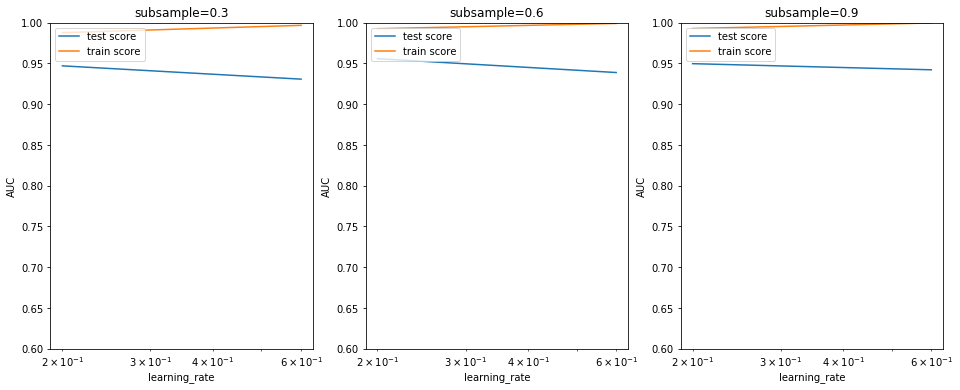

In [207]:
# # plotting
plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')


It is clear from the plot above that the model with a lower subsample ratio performs better, while those with higher subsamples tend to overfit. 

Also, a lower learning rate results in less overfitting.

### XGBoost

Let's finally try XGBoost. The hyperparameters are the same, some important ones being ```subsample```, ```learning_rate```, ```max_depth``` etc.


In [188]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [189]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[  9.99876201e-01,   1.23777572e-04],
       [  9.99802351e-01,   1.97641290e-04],
       [  9.99812186e-01,   1.87795449e-04],
       [  9.99353409e-01,   6.46599103e-04],
       [  9.98394549e-01,   1.60545984e-03],
       [  9.99828875e-01,   1.71130727e-04],
       [  9.99547005e-01,   4.52976237e-04],
       [  9.99449134e-01,   5.50867291e-04],
       [  9.99769509e-01,   2.30486505e-04],
       [  9.96964693e-01,   3.03530321e-03]], dtype=float32)

In [190]:
# evaluate predictions
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 94.85%


The roc_auc in this case is about 0.95% with default hyperparameters. Let's try changing the hyperparameters - an exhaustive list of XGBoost hyperparameters is here: http://xgboost.readthedocs.io/en/latest/parameter.html


Let's now try tuning the hyperparameters using k-fold CV. We'll then use grid search CV to find the optimal values of hyperparameters.

In [197]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [198]:
# fit the model
model_cv.fit(X_train, y_train)       

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.2, 0.6], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [202]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,3.741100,0.152881,0.946876,0.987553,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",3,0.921358,0.987602,0.970999,0.984654,0.948272,0.990403,0.070536,0.008717,0.020290,0.002347
1,4.502307,0.145803,0.955664,0.992432,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",1,0.932223,0.993281,0.978847,0.989872,0.955924,0.994144,0.161122,0.003679,0.019035,0.001844
2,3.939432,0.142248,0.949553,0.992693,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",2,0.923093,0.994291,0.975838,0.990117,0.949727,0.993671,0.025845,0.009256,0.021534,0.001839
3,3.833046,0.139765,0.930576,0.996570,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",6,0.922870,0.998300,0.962399,0.994786,0.906458,0.996624,0.046223,0.007278,0.023479,0.001435
4,4.475229,0.145708,0.938695,0.998893,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",5,0.902451,0.999039,0.967118,0.998233,0.946516,0.999408,0.031418,0.001555,0.026974,0.000491
5,3.820696,0.128931,0.942048,0.999459,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",4,0.905331,0.999469,0.973174,0.999409,0.947640,0.999500,0.063617,0.002741,0.027978,0.000038


In [ ]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results['param_max_depth'] = cv_results['param_max_depth'].astype('float')
cv_results.head()

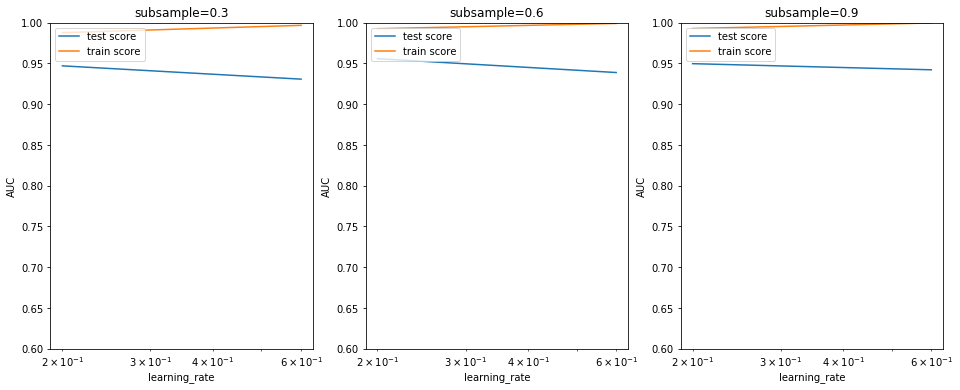

In [203]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

The results show that a subsample size of 0.6 and learning_rate of about 0.2 seems optimal. 
Also, XGBoost has resulted in the highest ROC AUC obtained (across various hyperparameters). 


Let's build a final model with the chosen hyperparameters.

In [204]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       params={'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.2, 'subsample': 0.6, 'objective': 'binary:logistic'},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [205]:
# predict
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[  9.99876201e-01,   1.23777572e-04],
       [  9.99802351e-01,   1.97641290e-04],
       [  9.99812186e-01,   1.87795449e-04],
       [  9.99353409e-01,   6.46599103e-04],
       [  9.98394549e-01,   1.60545984e-03],
       [  9.99828875e-01,   1.71130727e-04],
       [  9.99547005e-01,   4.52976237e-04],
       [  9.99449134e-01,   5.50867291e-04],
       [  9.99769509e-01,   2.30486505e-04],
       [  9.96964693e-01,   3.03530321e-03]], dtype=float32)

The first column in y_pred is the P(0), i.e. P(not fraud), and the second column is P(1/fraud).

In [206]:
# roc_auc
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])
auc

0.94848687324257352

Finally, let's also look at the feature importances.

In [225]:
# feature importance
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'app': 0.28301886,
 'channel': 0.23584905,
 'day_of_week': 0.006289308,
 'day_of_year': 0.0,
 'device': 0.13522013,
 'hour': 0.059748426,
 'ip': 0.067610063,
 'ip_count': 0.11006289,
 'ip_day_hour': 0.0,
 'ip_hour_app': 0.0,
 'ip_hour_channel': 0.0,
 'ip_hour_device': 0.0,
 'ip_hour_os': 0.039308175,
 'month': 0.0,
 'os': 0.062893085}

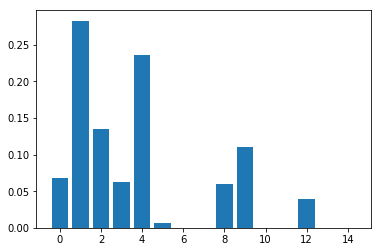

In [228]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

## Predictions on Test Data

Since this problem is hosted on Kaggle, you can  choose to make predictions on the test data and submit your results. Please note the following points and recommendations if you go ahead with Kaggle:

Recommendations for training:
- We have used only a fraction of the training set (train_sample, 100k rows), the full training data on Kaggle (train.csv) has about 180 million rows. You'll get good results only if you train the model on a significant portion of the training dataset.  
- Because of the size, you'll need to use Kaggle kernels to train the model on full training data. Kaggle kernels provide powerful computation capacities on cloud (for free). 
- Even on the kernel, you may need to use a portion of the training dataset (try using the last 20-30 million rows).
- Make sure you save memory by following some tricks and best practices, else you won't be able to train the model at all on a large dataset.



In [ ]:
# # read submission file
# sample_sub = pd.read_csv(path+'sample_submission.csv')
# sample_sub.head()

In [ ]:
# # predict probability of test data
# test_final = pd.read_csv(path+'test.csv')
# test_final.head()

In [ ]:
# # predictions on test data
# test_final = timeFeatures(test_final)
# test_final.head()

In [ ]:
# test_final.drop(['click_time', 'datetime'], axis=1, inplace=True)

In [ ]:
# test_final.head()

In [ ]:
# test_final[categorical_cols]=test_final[categorical_cols].apply(lambda x: le.fit_transform(x))

In [ ]:
# test_final.info()

In [ ]:
# # number of clicks by IP
# ip_count = test_final.groupby('ip')['channel'].count().reset_index()
# ip_count.columns = ['ip', 'count_by_ip']
# ip_count.head()

In [ ]:
# merge this with the training data
# test_final = pd.merge(test_final, ip_count, on='ip', how='left')

In [ ]:
# del ip_count

In [ ]:
# test_final.info()

In [ ]:
# # predict on test data
# y_pred_test = model.predict_proba(test_final.drop('click_id', axis=1))
# y_pred_test[:10]

In [ ]:
# # # create submission file
# sub = pd.DataFrame()
# sub['click_id'] = test_final['click_id']
# sub['is_attributed'] = y_pred_test[:, 1]
# sub.head()

In [ ]:
# sub.to_csv('kshitij_sub_03.csv', float_format='%.8f', index=False)

In [ ]:
# # model

# dtrain = xgb.DMatrix(X_train, y_train)
# del X_train, y_train
# gc.collect()

# watchlist = [(dtrain, 'train')]
# model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

In [ ]:
# del dtrain
# gc.collect()

In [ ]:
# # Plot the feature importance from xgboost
# plot_importance(model)
# plt.gcf().savefig('feature_importance_xgb.png')


In [ ]:
# # Load the test for predict 
# test = pd.read_csv(path+"test.csv")

In [ ]:
# test.head()

In [ ]:
# # number of clicks by IP
# ip_count = train_sample.groupby('ip')['channel'].count().reset_index()
# ip_count.columns = ['ip', 'count_by_ip']
# ip_count.head()

In [ ]:
# test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
# gc.collect()

In [ ]:
# test = timeFeatures(test)
# test.drop(['click_time', 'datetime'], axis=1, inplace=True)
# test.head()

In [ ]:
# print(test.columns)
# print(train_sample.columns)

In [ ]:
# test = test[['click_id','ip', 'app', 'device', 'os', 'channel', 'day_of_week',
#        'day_of_year', 'month', 'hour', 'count_by_ip']]

In [ ]:
# dtest = xgb.DMatrix(test.drop('click_id', axis=1))

In [ ]:
# # Save the predictions
# sub = pd.DataFrame()
# sub['click_id'] = test['click_id']

# sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
# sub.to_csv('xgb_sub.csv', float_format='%.8f', index=False)

In [ ]:
# sub.shape